# **Phishing vs Legitimate Detection**

## **Inquiry Pipeline:**
* **1) Imports & Config**
* **2) Load Data**
* **3) Quick Data Audit**
* **4) Target Column Detection**
* **5) Features & Basic Cleaning**
* **6) EDA: Class Balance**
* **7) EDA: Correlations For Numeric Features**
* **8) EDA: Top Feature Distributions**
* **9) Feature Selection (Optional)**
* **10) Train/Val Split**
* **11) Model Pipelines**
* **12) Train & Evaluate (Holdout) — FIXED VERSION**
* **13) Cross-Validation Leaderboard**
* **14) Feature Importance (Tree-Based) — FINAL FIX**
* **15) Save Best Model (Optional)**

## **1) Imports & Config**

In [1]:
import os
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import SelectKBest, mutual_info_classif

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, f1_score, classification_report,confusion_matrix, RocCurveDisplay, roc_auc_score)
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate


try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# Plot style
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True
sns.set(context="notebook", style="whitegrid")

RANDOM_STATE = 42
pd.set_option("display.max_columns", 200)

## **2) Load Data**

In [2]:
df = pd.read_csv("D:/PYTHON 2/ᗪᗩTᗩ/OCTOBER/Machine Learning (ML)/Phishing Dataset for Machine Learning/CSV/Phishing_Legitimate_full.csv")
print("✅ Loaded successfully!")
print("Shape:", df.shape)
df.head()

✅ Loaded successfully!
Shape: (10000, 50)


,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,NumPercent,NumQueryComponents,NumAmpersand,NumHash,NumNumericChars,NoHttps,RandomString,IpAddress,DomainInSubdomains,DomainInPaths,HttpsInHostname,HostnameLength,PathLength,QueryLength,DoubleSlashInPath,NumSensitiveWords,EmbeddedBrandName,PctExtHyperlinks,PctExtResourceUrls,ExtFavicon,InsecureForms,RelativeFormAction,ExtFormAction,AbnormalFormAction,PctNullSelfRedirectHyperlinks,FrequentDomainNameMismatch,FakeLinkInStatusBar,RightClickDisabled,PopUpWindow,SubmitInfoToEmail,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,1,3,1,5,72,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,21,44,0,0,0,0,0.000,0.250000,1,1,0,0,0,0.0,0,0,0,0,0,0,0,1,1,0,1,1,-1,1,1
1,2,3,1,3,144,0,0,0,0,2,0,2,1,0,41,1,0,0,0,0,0,17,16,103,0,1,0,0.000,0.000000,0,1,0,0,0,0.0,0,0,0,0,0,0,0,0,1,-1,1,1,1,1,1
2,3,3,1,2,58,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,27,24,0,0,0,0,0.375,1.000000,1,1,0,0,0,0.0,0,0,0,0,0,0,0,0,1,0,-1,1,-1,0,1
3,4,3,1,6,79,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,22,50,0,0,0,1,1.000,0.095238,1,1,0,0,0,0.0,1,0,0,0,1,0,0,0,1,-1,1,1,1,-1,1
4,5,3,0,4,46,0,0,0,0,0,0,0,0,0,2,1,1,0,0,1,0,10,29,0,0,0,0,1.000,1.000000,0,0,0,1,0,0.0,1,0,0,0,0,1,0,0,1,1,-1,0,-1,-1,1


## **3) Quick Data Audit**

<Axes: >

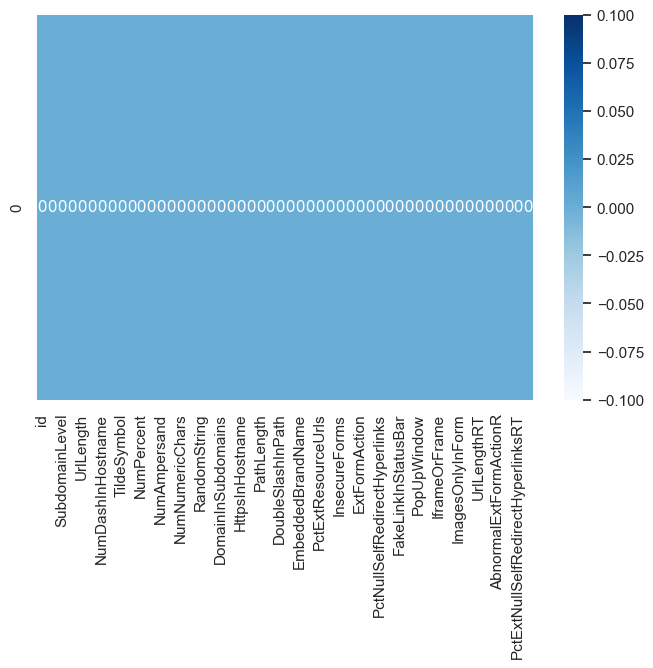

In [3]:
sns.heatmap(df.isnull().sum().to_frame().T, annot=True, cmap='Blues')

## **4) Target Column Detection**

In [4]:
Column_Targets = [
    "label", "Label", "LABEL",
    "target", "Target", "TARGET",
    "class", "Class", "CLASS",
    "Result", "RESULT",
    "is_phishing", "phishing", "Phishing", "PHISHING",
    "legitimate", "y", "Y"
]

TARGET = None
for c in Column_Targets:
    if c in df.columns:
        TARGET = c
        break

if TARGET is None:
    binary_candidates = [
        c for c in df.columns 
        if df[c].nunique() <= 3 and c.lower() not in ("id",)
    ]
    TARGET = binary_candidates[0] if binary_candidates else None

print("Detected TARGET:", TARGET)

assert TARGET is not None, (
    "Couldn't auto-detect the target column. "
    "Please set TARGET = '<your_target_col>' and re-run this cell."
)

y_raw = df[TARGET]

if y_raw.dtype == object:
    vals = y_raw.value_counts().index.tolist()
    if len(vals) == 2:
        
        mapping = {vals[0]: 0, vals[1]: 1}
        y = y_raw.map(mapping)
    else:
        # Heuristic: mark phishing-like labels as 1
        y = y_raw.astype(str).str.lower().str.contains("phish|fraud|mal|bad").astype(int)
else:
    y = y_raw.astype(int)

mask_notna = y.notna()
df = df.loc[mask_notna].reset_index(drop=True)
y = y.loc[mask_notna].reset_index(drop=True)

print("Target distribution:\n", y.value_counts(dropna=False))

Detected TARGET: AtSymbol
Target distribution:
 AtSymbol
0    9997
1       3
Name: count, dtype: int64


## **5) Features & Basic Cleaning**

In [5]:
id_like = [c for c in df.columns if re.search(r'(^id$|_id$|^index$)', c, flags=re.I)]
id_like = [c for c in id_like if c != TARGET]
if id_like:
    df = df.drop(columns=id_like)
X = df.drop(columns=[TARGET], errors="ignore")
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_features),
        ("cat", categorical_pipe, categorical_features)
    ],
    remainder="drop"
)

Numeric features: 48
Categorical features: 0


## **6) EDA: Class Balance**

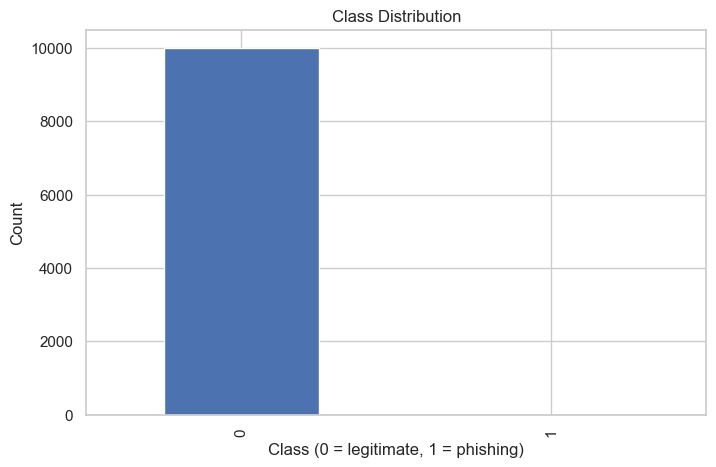

Class ratio (minority%): 0.03 %


In [6]:
Class_Counts = y.value_counts().sort_index()
ax = Class_Counts.plot(kind="bar")
ax.set_title("Class Distribution")
ax.set_xlabel("Class (0 = legitimate, 1 = phishing)")
ax.set_ylabel("Count")
plt.show()

print("Class ratio (minority%):", round(Class_Counts.min() / Class_Counts.sum() * 100, 2), "%")

## **7) EDA: Correlations For Numeric Features**

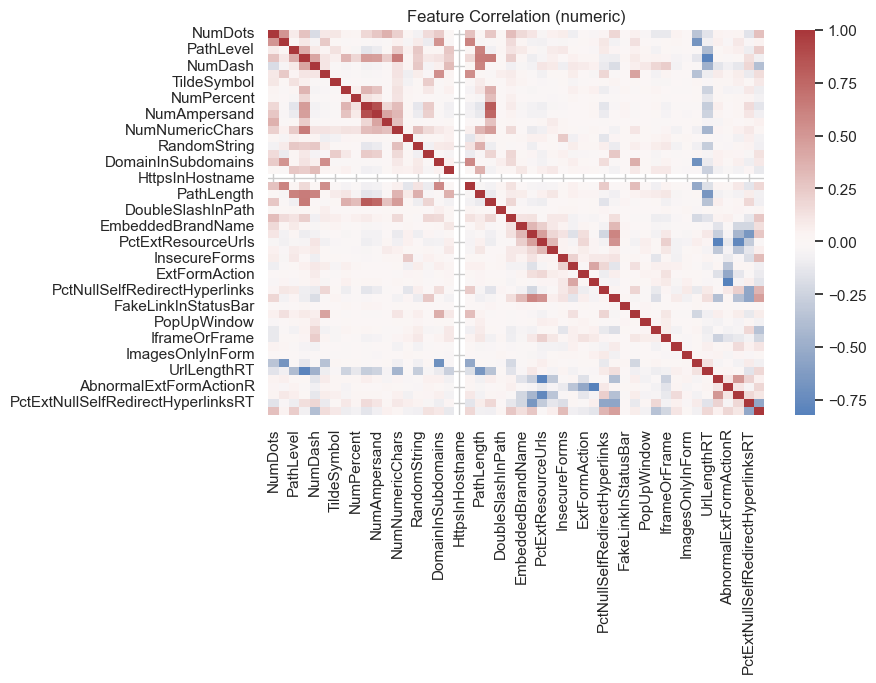

In [7]:
if len(numeric_features) >= 2:
    corr = X[numeric_features].corr(numeric_only=True)
    sns.heatmap(corr, cmap="vlag", center=0)
    plt.title("Feature Correlation (numeric)")
    plt.show()
else:
    print("Not enough numeric features for a correlation heatmap.")

## **8) EDA: Top Feature Distributions**

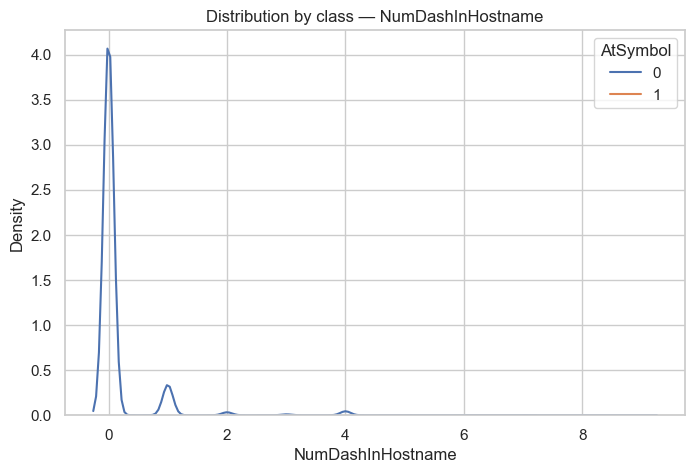

In [8]:
Top_Show = numeric_features[:6]

for col in Top_Show:
    if X[col].nunique() <= 1:
        print(f"Skipping {col} (0 variance)")
        continue
fig, ax = plt.subplots()
sns.kdeplot(x=X[col], hue=y, ax=ax, common_norm=False, warn_singular=False)
ax.set_title(f"Distribution by class — {col}")
plt.show()

## **9) Feature Selection (Optional)**

In [9]:
USE_FEATURE_SELECTION = True
K_FEATURES = min(50, max(10, int(X.shape[1] * 0.5)))

selector = None
if USE_FEATURE_SELECTION:
    pre_X = preprocessor.fit_transform(X, y)
    mi = mutual_info_classif(pre_X, y, random_state=RANDOM_STATE)
    print(f"Mutual Information computed on {pre_X.shape[1]} encoded features.")
else:
    print("Feature selection skipped.")

Mutual Information computed on 48 encoded features.


## **10) Train/Val Split**

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)

Train shape: (8000, 48) | Test shape: (2000, 48)


## **11) Model Pipelines**

In [11]:
def make_model_pipeline(estimator, use_selectk=True, k=K_FEATURES):
    steps = [("prep", preprocessor)]
    if use_selectk:
        steps.append(("select", SelectKBest(score_func=mutual_info_classif, k=min(k,  X.shape[1]*5 if categorical_features else k))))
    steps.append(("clf", estimator))
    return Pipeline(steps)

models = {
    "LogisticRegression": LogisticRegression(max_iter=200, n_jobs=None if hasattr(LogisticRegression(), "n_jobs") else None),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE)
}
if HAS_XGB:
    models["XGBoost"] = XGBClassifier(
        n_estimators=400, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8,
        eval_metric="logloss", random_state=RANDOM_STATE, n_jobs=-1
    )

pipelines = {name: make_model_pipeline(clf) for name, clf in models.items()}
list(pipelines.keys())

['LogisticRegression',
 'DecisionTree',
 'RandomForest',
 'GradientBoosting',
 'XGBoost']

## **12) Train & Evaluate (Holdout) — FIXED VERSION**


 LogisticRegression
 Accuracy: 0.9995 |  F1 Score: 0.0000 |  ROC-AUC: 0.9102

 Classification Report:
              precision    recall  f1-score   support

           0     0.9995    1.0000    0.9997      1999
           1     0.0000    0.0000    0.0000         1

    accuracy                         0.9995      2000
   macro avg     0.4998    0.5000    0.4999      2000
weighted avg     0.9990    0.9995    0.9993      2000



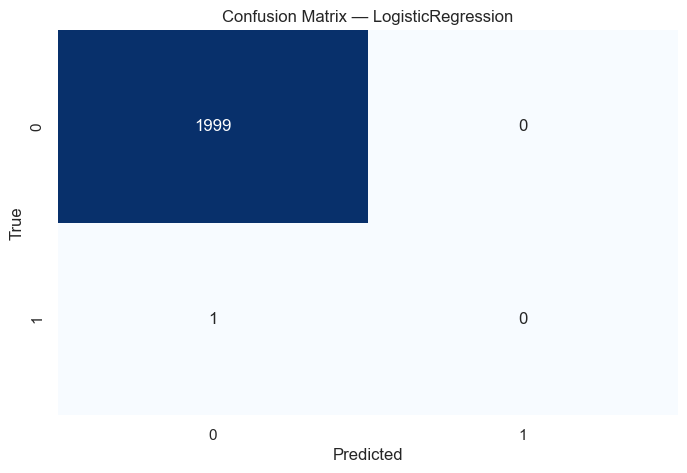

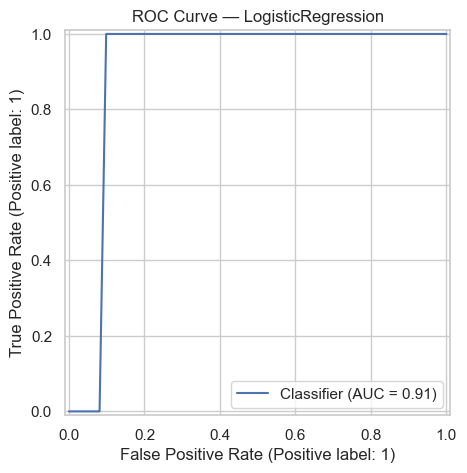


 DecisionTree
 Accuracy: 0.9995 |  F1 Score: 0.0000 |  ROC-AUC: 0.4987

 Classification Report:
              precision    recall  f1-score   support

           0     0.9995    1.0000    0.9997      1999
           1     0.0000    0.0000    0.0000         1

    accuracy                         0.9995      2000
   macro avg     0.4998    0.5000    0.4999      2000
weighted avg     0.9990    0.9995    0.9993      2000



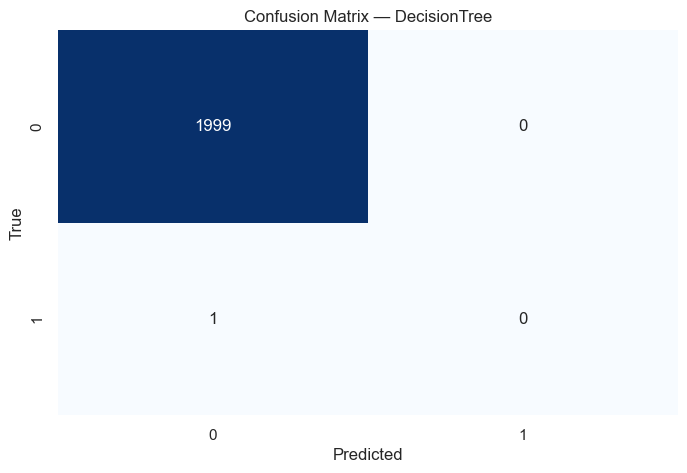

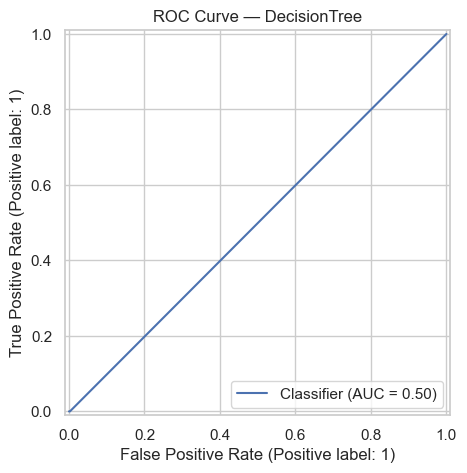


 RandomForest
 Accuracy: 0.9995 |  F1 Score: 0.0000 |  ROC-AUC: 0.4960

 Classification Report:
              precision    recall  f1-score   support

           0     0.9995    1.0000    0.9997      1999
           1     0.0000    0.0000    0.0000         1

    accuracy                         0.9995      2000
   macro avg     0.4998    0.5000    0.4999      2000
weighted avg     0.9990    0.9995    0.9993      2000



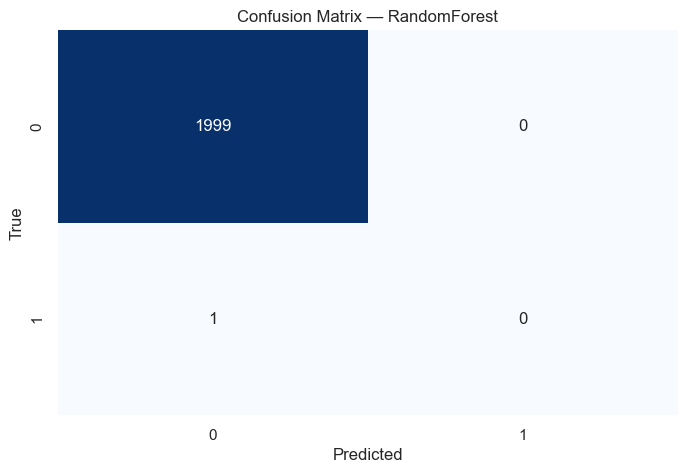

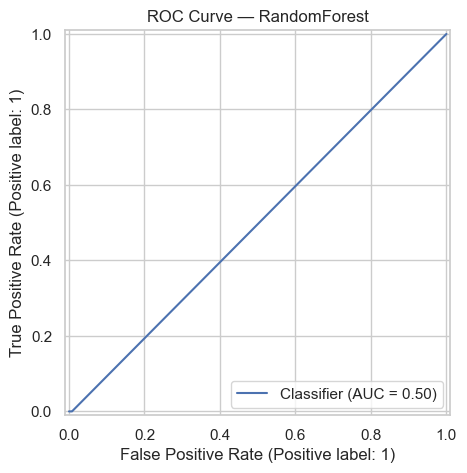


 GradientBoosting
 Accuracy: 0.9995 |  F1 Score: 0.0000 |  ROC-AUC: 0.6733

 Classification Report:
              precision    recall  f1-score   support

           0     0.9995    1.0000    0.9997      1999
           1     0.0000    0.0000    0.0000         1

    accuracy                         0.9995      2000
   macro avg     0.4998    0.5000    0.4999      2000
weighted avg     0.9990    0.9995    0.9993      2000



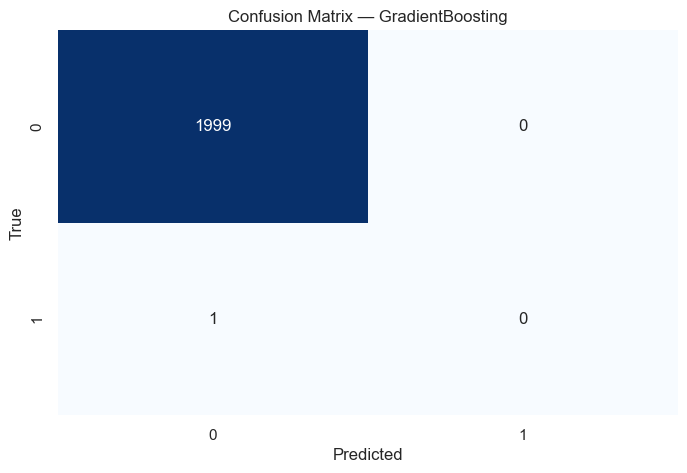

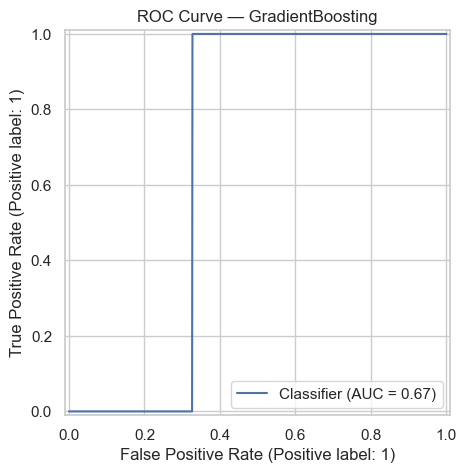


 XGBoost
 Accuracy: 0.9995 |  F1 Score: 0.0000 |  ROC-AUC: 0.5000

 Classification Report:
              precision    recall  f1-score   support

           0     0.9995    1.0000    0.9997      1999
           1     0.0000    0.0000    0.0000         1

    accuracy                         0.9995      2000
   macro avg     0.4998    0.5000    0.4999      2000
weighted avg     0.9990    0.9995    0.9993      2000



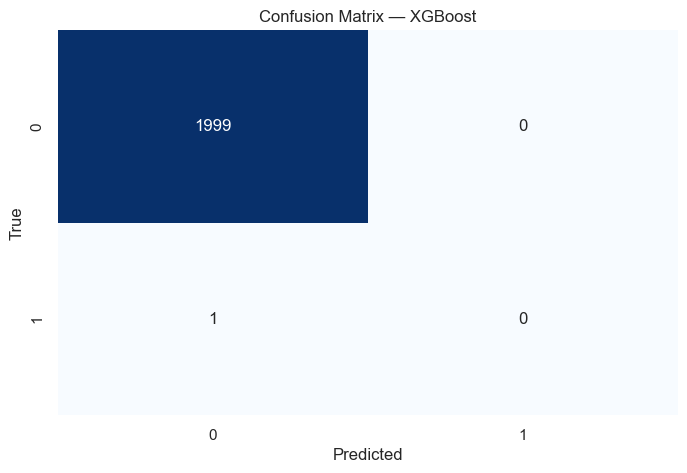

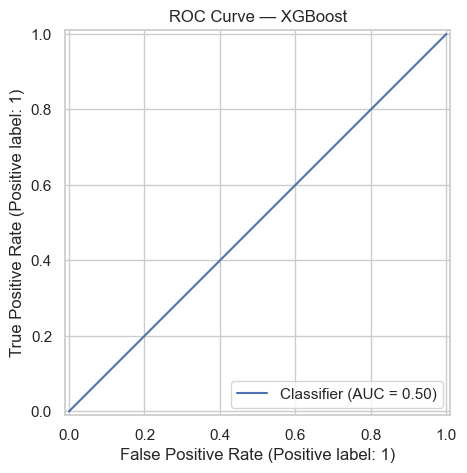


 Leaderboard (Holdout Results):


,name,accuracy,f1,roc_auc
0,LogisticRegression,0.9995,0.0,0.910205
1,GradientBoosting,0.9995,0.0,0.673337
2,XGBoost,0.9995,0.0,0.500000
3,DecisionTree,0.9995,0.0,0.498749
4,RandomForest,0.9995,0.0,0.495998


In [12]:
def evaluate_model(name, pipe, X_train, y_train, X_test, y_test):

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    proba = None

    
    if hasattr(pipe, "predict_proba"):
        try:
            proba = pipe.predict_proba(X_test)[:, 1]
        except Exception:
            proba = None


    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, zero_division=0)
    roc = roc_auc_score(y_test, proba) if proba is not None else np.nan


    print(f"\n {name}")
    print(f" Accuracy: {acc:.4f} |  F1 Score: {f1:.4f} |  ROC-AUC: {roc:.4f}")


    print("\n Classification Report:")
    print(classification_report(y_test, preds, digits=4, zero_division=0))


    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


    if proba is not None:
        RocCurveDisplay.from_predictions(y_test, proba)
        plt.title(f"ROC Curve — {name}")
        plt.show()


    return {"name": name, "accuracy": acc, "f1": f1, "roc_auc": roc}



results = []
for name, pipe in pipelines.items():
    metrics = evaluate_model(name, pipe, X_train, y_train, X_test, y_test)
    results.append(metrics)


leaderboard = (
    pd.DataFrame(results)
    .sort_values(by=["f1", "roc_auc", "accuracy"], ascending=False)
    .reset_index(drop=True)
)

print("\n Leaderboard (Holdout Results):")
display(leaderboard)

## **13) Cross-Validation Leaderboard**

In [13]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=RANDOM_STATE)

cv_rows = []
for name, pipe in pipelines.items():
    scores = cross_validate(
        pipe, X, y, cv=cv,
        scoring=["accuracy", "f1", "roc_auc"],
        n_jobs=-1, error_score="raise"
    )
    cv_rows.append({
        "model": name,
        "cv_acc_mean": scores["test_accuracy"].mean(),
        "cv_f1_mean": scores["test_f1"].mean(),
        "cv_roc_auc_mean": scores["test_roc_auc"].mean()
    })

cv_board = (
    pd.DataFrame(cv_rows)
    .sort_values(by=["cv_f1_mean", "cv_roc_auc_mean", "cv_acc_mean"], ascending=False)
)
print("Cross-Validation (Shuffle, 5 splits) Leaderboard:")
display(cv_board.reset_index(drop=True))

Cross-Validation (Shuffle, 5 splits) Leaderboard:


,model,cv_acc_mean,cv_f1_mean,cv_roc_auc_mean
0,LogisticRegression,0.9995,0.0,0.922361
1,GradientBoosting,0.9995,0.0,0.886243
2,XGBoost,0.9995,0.0,0.500000
3,RandomForest,0.9995,0.0,0.497299
4,DecisionTree,0.9995,0.0,0.495748


## **14) Feature Importance (Tree-Based) — FINAL FIX**

Could not extract categorical feature names: This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
Length mismatch: 24 importances vs 48 features.


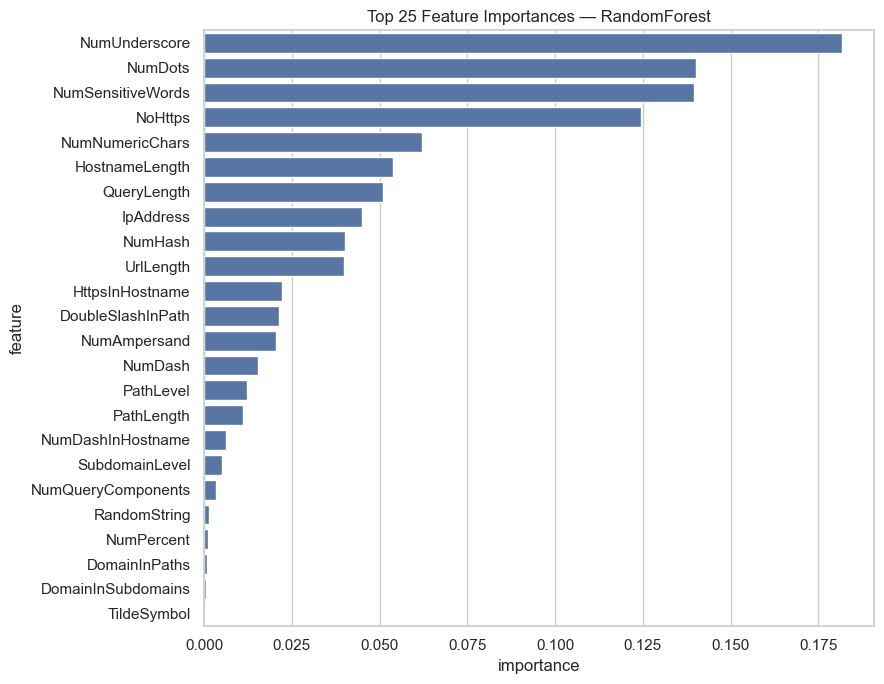

,feature,importance
7,NumUnderscore,0.181739
0,NumDots,0.140242
23,NumSensitiveWords,0.139634
13,NoHttps,0.124391
12,NumNumericChars,0.061956
19,HostnameLength,0.053777
21,QueryLength,0.050952
15,IpAddress,0.045081
11,NumHash,0.040066
3,UrlLength,0.039996


In [14]:
rf_pipe = pipelines["RandomForest"]
rf_pipe.fit(X_train, y_train)

prep = rf_pipe.named_steps["prep"]
num_names = numeric_features

cat_names = []
try:
    ohe = prep.named_transformers_["cat"].named_steps["onehot"]
    cat_names = ohe.get_feature_names_out(categorical_features).tolist()
except Exception as e:
    print("Could not extract categorical feature names:", e)

feature_names = np.array(num_names + cat_names)

clf = rf_pipe.named_steps["clf"]

if hasattr(clf, "feature_importances_"):
    importances = clf.feature_importances_
    if len(importances) != len(feature_names):
        print(f"Length mismatch: {len(importances)} importances vs {len(feature_names)} features.")
        feature_names = feature_names[:len(importances)]
else:
    print("Using permutation importance instead (no native feature_importances_)")
    r = permutation_importance(rf_pipe, X_test, y_test, n_repeats=10, random_state=42)
    importances = r.importances_mean
    feature_names = feature_names[:len(importances)]

imp_df = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
    .sort_values("importance", ascending=False)
    .head(25)
)

plt.figure(figsize=(9, 7))
sns.barplot(data=imp_df, x="importance", y="feature")
plt.title("Top 25 Feature Importances — RandomForest")
plt.tight_layout()
plt.show()

display(imp_df)

## **15) Save Best Model (Optional)**

In [15]:
Best_Name = leaderboard.iloc[0]["name"]
best_pipe = pipelines[Best_Name].fit(X, y)

print("Best model:", Best_Name)

import joblib
joblib.dump(best_pipe, f"{Best_Name}_phishing_model.joblib")
print(f"Saved: {Best_Name}_phishing_model.joblib")

Best model: LogisticRegression
Saved: LogisticRegression_phishing_model.joblib
